# Numpy-based Neural Network engine from scratch

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/m12sl/short-dl/blob/master/01-introduction/nn_from_scratch.ipynb)


В этой тетрадке мы напишем маленький фреймворк для создания и обучения нейронной сети.

**Цели тетрадки**

1. Понять, что лежит в основе DL фреймворков
2. Разобраться с бекпропом на примере простых слоев
3. Встретить характерные для векторизованных вычислений ошибки
4. Вспомнить особенности операций с плавающей точкой
5. Попробовать тестировать код сразу


**План работы**

0. Обсудить векторизацию вычислений и договориться о формате входных-выходных данных
1. Рассмотреть как высокоуровнево устроен движок для сеток
2. Реализовать несколько базовых слоев
3. Натренировать простую сеть на задаче MNIST

In [1]:
%matplotlib inline
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm

# Векторизация вычислений (batchification)

<img src="https://github.com/m12sl/dl-hse-2020/raw/master/01-introduction/img/graph_vector.png" crossorigin="anonymous"/>

В современных компьютерах выгодно объединять данные в массивы и применять векторизованные операции.

На практике во всех фреймворках для DL работают с данными упакованными в батчи: 
многомерные массивы с размерами `[batch_size, channels, *spatial_dimensions]` -- такие массивы называются тензорами. 

Подразумевается, что примеры в батче независимы друг от друга и никак не влияют друг на друга (за исключением некоторых нормализаций и специальных трюков).


<img src="https://github.com/m12sl/dl-hse-2020/raw/master/01-introduction/img/graph_batched.png" crossorigin="anonymous"/>


Предлагается реализовать простой движок для обучения простейших нейронных сетей (MLP, Multi Layer Perceptron).
Для этого нам будет достаточно нескольких строительных блоков:

- класс для цепочки слоев (Sequential)
- классы для слоев (реализации операций)
- train loop


Для простоты предлагается совместить backward-проход с градиентным спуском.
Если слой содержит веса, надо будет их обновить в коде `backward`-метода.

In [2]:
# Этот слой можно было бы назвать Identity, он пропускает данные и градиенты без изменений
class Layer:
    def forward(self, input):
        # store something if needed
        return input
    
    def backward(self, grads):
        # apply grads here if any
        return grads


class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def forward(self, input):
        x = input
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, grads):
        for layer in self.layers[::-1]:
            grads = layer.backward(grads)
        return grads

In [3]:
# Сеть которая не делает ничего
network = Sequential([Layer(), Layer()])

x = np.random.random(size=(3, 5))
output = network.forward(x)
assert output.shape == (3, 5)

y = np.ones((3, 5))
grads = network.backward(y)
assert grads.shape == (3, 5)

У нас есть блоки которые преобразуют вектора в вектора. Технически, этого достаточно чтобы решать задачи регрессии, однако классической задачей для MLP считается классификация.

Чтобы решать задачи классификации нам не хватает еще нескольких операций

## softmax 

Это функция, которая превращает произвольный вектор в корректное распределение вероятностей (неотрицательные числа, суммирующиеся в 1) $$q_i = \frac{\exp(x_i)}{\sum \limits_{j} \exp(x_j)}$$


## cross-entropy loss (перекрестная энтропия)

$$H(\mathbf{p}, \mathbf{q}) = -\sum \limits_i p_i \log q_i$$.

Эта формула описывает близость между двумя распределениями вероятностей:
 - $i$ --- номер класса,
 - $p_i$ --- правильная вероятность класса (единица, еcли правильная метка i, ноль, если нет)
 - $q_i$ --- предсказанная вероятность (выход softmax'а).
 
В математическом смысле кросс-энтропия не является расстоянием, в частности потому что меняется при перестановке аргументов.



Вычисление экспонент и логарифмов часто ведет к накоплению ошибок, поэтому часто вместо вычисления вероятностей вычисляют логиты ($\log \mathrm{softmax}$) и из формулы для лосса убирают логарифмы.

При использовании фреймворков обяхательно надо сверяться с документацией, какие аргументы ожидаются на вход. В лучшем случае в коде есть проверки и мы получим исключение, в худшем -- все будет молча плохо работать.
Типичное название для такой лосс-функции `cross_entropy_with_logits`.



## Math vs implementation

Нас не интересует строгое соответствие математической нотации, она годится для работы с векторами. Мы же работаем с данными собранными в батчи.


Для простоты договоримся, что данные лежат в массивах `numpy.ndarray` с размерностями `[bs, dim]`.

## Multilayer Perceptron (MLP)

<img src="https://github.com/m12sl/dl-hse-2020/raw/master/01-introduction/img/graph_mlp.png" crossorigin="anonymous"/>


Нам потребуется реализовать следующие слои:

```
Linear
Relu
```


## Linear Layer

Синонимы: Linear, Dense, FullyConnected, Projection:

Математическое действие над вектором признаков:
$$\mathbf{y} = W \mathbf{x} + \mathbf{b}$$

Пусть 
$\mathbf{x} \in \mathbb{R}^n$
$\mathbf{y}\in \mathbb{R}^m$

**Какую размерность должен иметь $W$ и $b$?**

W - m x n; 
b - m x 1;

Давайте теперь реализуем векторизованный вариант слоя: `y = f(x, W, b)`

```python
x.shape == (batch_size, in_channels)
y.shape == (batch_size, out_channels)
```

Напишите код для вычисления прямого прохода и обратного в векторизованной форме.
Шаг градиентного спуска предлагается совместить с обратным проходом.

Веса $W, b$ считаем принадлежащими слою, инициализируем при создании, во время обратного прохода возвращаем градиенты только за входной тензор.

In [4]:
# Реализуйте линейный слой
# y = Wx + b

class Linear(Layer):
    def __init__(self, in_channels, out_channels, learning_rate=0.1):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W = np.random.randn(in_channels, out_channels) * 0.01
        self.b = np.zeros(out_channels)
        self.learning_rate = learning_rate
        # for debug purpose
        self.grad_W = None
        self.grad_b = None
        self.grad = None
    
    def forward(self, x):
        self.x = x
        y = x.dot(self.W) + self.b
        return y
    
    def backward(self, grad):
        grad_W = self.x.T.dot(grad)
        grad_b = grad.sum(axis=0)
        grad = grad.dot(self.W.T)
        
        # применение градиентов
        self.W = self.W - grad_W * self.learning_rate
        self.b = self.b - grad_b * self.learning_rate
        
        # это может пригодиться для дебага
        self.grad_W = grad_W
        self.grad_b = grad_b
        self.grad = grad
        return grad

    
# тесты для самопроверки
linear = Linear(5, 7)

x = np.random.random(size=(3, 5))
assert linear.forward(x).shape == (3, 7), "Forward pass shape mistmatch"

y = np.random.random(size=(3, 7))
grad_x = linear.backward(y)
assert grad_x.shape == (3, 5)
assert linear.grad_W.shape == linear.W.shape
assert linear.grad_b.shape == linear.b.shape

## ReLU Layer

Это простая поэлементная операция, записывается как $f(x) = max(x, 0)$.

**NB: активационные слои не меняют размер тензора**

In [5]:
class ReLU(Layer):
    def forward(self, input):
        self.x = input > 0
        y = np.maximum(input, 0)
        return y
    
    def backward(self, grad):
        grad = grad * self.x
        return grad
    
relu = ReLU()
x = np.random.normal(size=(3, 5))
assert relu.forward(x).shape == (3, 5)
assert np.all(relu.forward(x) >= 0.0)

y = np.random.normal(size=(3, 5))
grads = relu.backward(y)
assert grads.shape == (3, 5) 

# сверим с численным дифференцированием
approx = (relu.forward(x + 1e-5) - relu.forward(x)) / 1e-5

relu.forward(x)
assert np.allclose(relu.backward(np.ones_like(x)), approx)

Для подсчета ошибки нам необходимы предсказания сети и правильные ответы.

Для простоты подсчет ошибки и градиентов вынесены в отдельные функции вместе с вычислением вероятностей (softmax).

Каждая из функций ожидает на вход логиты -- тензор с размерами `[bs, num_classes]`.

`softmax_crossentropy_with_logits` возвращает одно число -- величину ошибки.

`grad_softmax_crossentropy_with_logits` возвращает тензор размером `[bs, num_classes]` с градиентами по логитам.


In [6]:
def softmax_crossentropy_with_logits(logits, reference_answers):
    """Compute crossentropy from logits[batch, n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)), reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy.mean()

def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)
    return (- ones_for_answers + softmax) / logits.shape[0]

## Data Handling
Для работы с данными во всех фреймворках есть Dataset/Dataloader классы.

Мы будем разбирать pytorch Data API отдельно, а пока предлагается воспользоваться готовым кодом:

In [7]:
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST

# в FashionMNIST уже есть код, который грузит данные и читает их в PIL.Image, мы конвертируем их в вектора.
# Непосредственно с картинками мы будем работать позже
def transform(pil_image):
    return np.asarray(pil_image).astype(np.float32).reshape(-1) / 255.0


def numpy_collate_fn(batch):
    x, y = list(zip(*batch))
    return np.array(x).astype(np.float32), np.array(y).astype(np.int32)


# dataset умеет выдавать отдельные семплы с метками
train_dataset = FashionMNIST("./tmp", train=True, download=True, transform=transform)
test_dataset = FashionMNIST("./tmp", train=False, download=True, transform=transform)
# dataloader выдает целые батчи и поддерживает итерирование
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32, collate_fn=numpy_collate_fn)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=32, collate_fn=numpy_collate_fn)

(784,) 9
float32 int32
(32, 784) (32,)


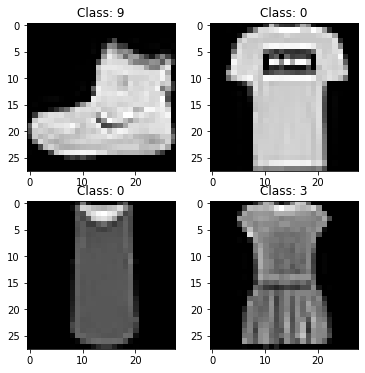

In [8]:
# dataset возвращает отдельные семплы
print(train_dataset[11][0].shape, train_dataset[11][1])

# dataloader целые батчи
for x, y in train_loader:
    print(x.dtype, y.dtype)
    print(x.shape, y.shape)
    break

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title(f"Class: {train_dataset[i][1]}")
    plt.imshow(train_dataset[i][0].reshape(28, 28),cmap='gray');

## Train Loop

Теперь все готово чтобы сделать сеть и проучить ее.
Если все реализовано правильно, можно ожидать точности на валидации $~0.86+$.

Кросс-энтропийный лосс не слишком показательная величина, но он должен оказаться $~0.4$ на валидации.
Если сеть не может вытащить ничего полезного из входа, в результате обучения можно ожидать тривиального ответа по вероятность $0.1$ для каждого класса. Это даст точность $0.1$ и кросс-энтропию порядка $\log 10 \approx 2.3$.

In [9]:
network = Sequential([
    Linear(784, 40),
    ReLU(), 
    Linear(40, 40),
    ReLU(),
    Linear(40, 10),
])

epochs = 10

# логи для построения кривых
logs = defaultdict(list)
train_logs = defaultdict(list)

for epoch in range(epochs):
    for x, y in tqdm(train_loader):
        logits = network.forward(x)
        loss = softmax_crossentropy_with_logits(logits, y)
        acc = np.mean(np.argmax(logits, axis=-1) == y)
        train_logs['train_loss'].append(loss)
        train_logs['train_acc'].append(acc)
        train_logs['epoch'].append(epoch)
        grads = grad_softmax_crossentropy_with_logits(logits, y)
        network.backward(grads)
        
    for x, y in tqdm(test_loader):
        logits = network.forward(x)
        loss = softmax_crossentropy_with_logits(logits, y)
        acc = np.mean(np.argmax(logits, axis=-1) == y)
        logs['test_loss'].append(loss)
        logs['test_acc'].append(acc)
        logs['epoch'].append(epoch)
        
    for k, v in logs.items():
        print(k, np.mean(v))


test_loss 0.54340188213045
test_acc 0.8050119808306709
epoch 0.0



test_loss 0.4924856827631737
test_acc 0.8211861022364217
epoch 0.5



test_loss 0.4704900398532497
test_acc 0.8298056443024494
epoch 1.0



test_loss 0.45565777257808526
test_acc 0.8347643769968051
epoch 1.5



test_loss 0.440867630632794
test_acc 0.8403554313099042
epoch 2.0



test_loss 0.4337284898567112
test_acc 0.8426018370607029
epoch 2.5



test_loss 0.4264686345697057
test_acc 0.8452903925148334
epoch 3.0



test_loss 0.41893824713535643
test_acc 0.8480556110223643
epoch 3.5



test_loss 0.4134144201456256
test_acc 0.8501286829960951
epoch 4.0



test_loss 0.4094149526432356
test_acc 0.8510283546325879
epoch 4.5


## кривые обучения

Постройте графики обучения: точность и лосс от количества шагов.

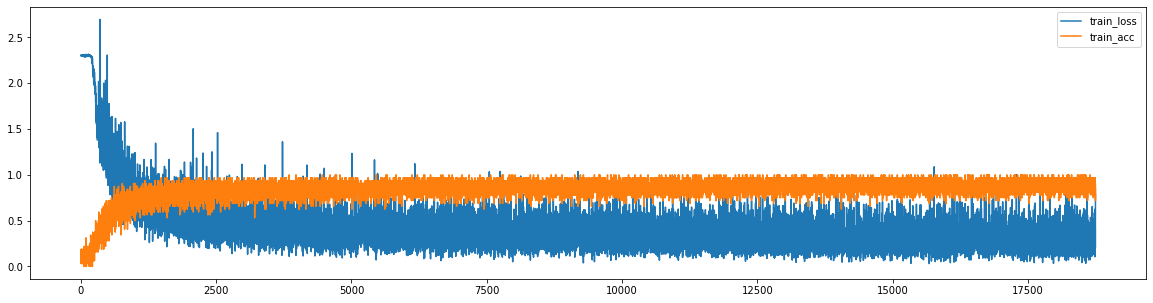

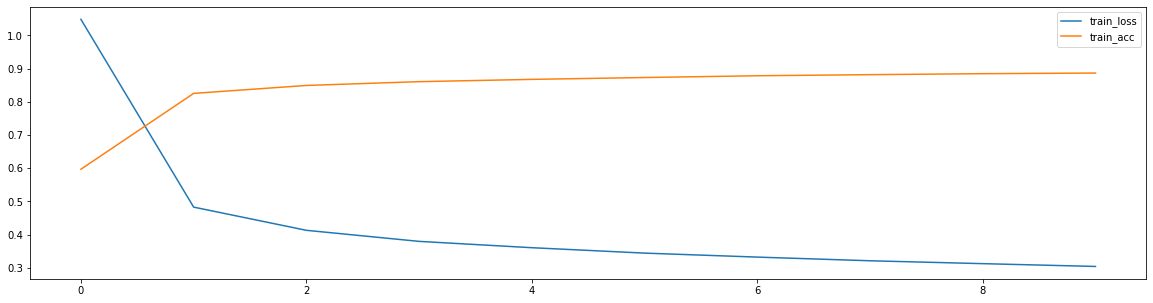

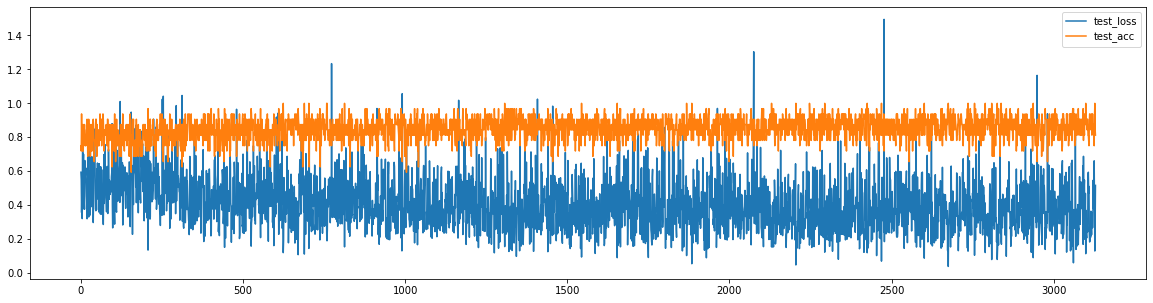

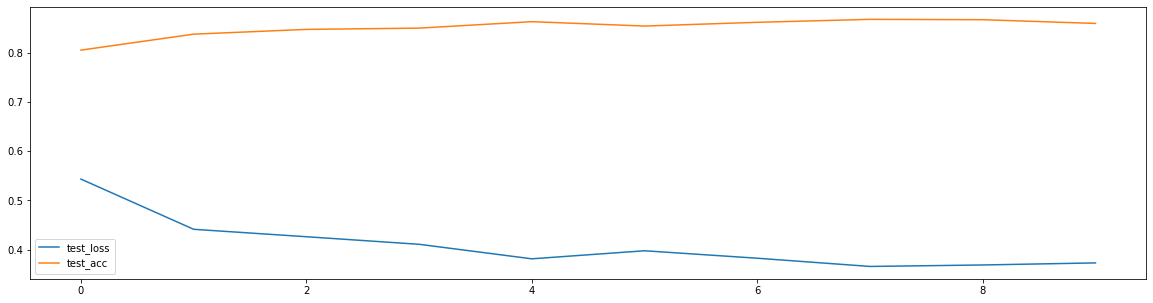

In [10]:
import pandas as pd

# Train set
train_logs = pd.DataFrame(train_logs)
train_logs[['train_loss', 'train_acc']].plot(figsize=(20, 5))
train_logs = train_logs.groupby(['epoch'], as_index=False).mean()
train_logs[['train_loss', 'train_acc']].plot(figsize=(20, 5))

# Validation set
test_logs = pd.DataFrame(logs)
test_logs[['test_loss', 'test_acc']].plot(figsize=(20, 5))
test_logs = test_logs.groupby(['epoch'], as_index=False).mean()
test_logs[['test_loss', 'test_acc']].plot(figsize=(20, 5))

## примеры предсказаний

Выведите пример картинок, предсказаний и правильных ответов.

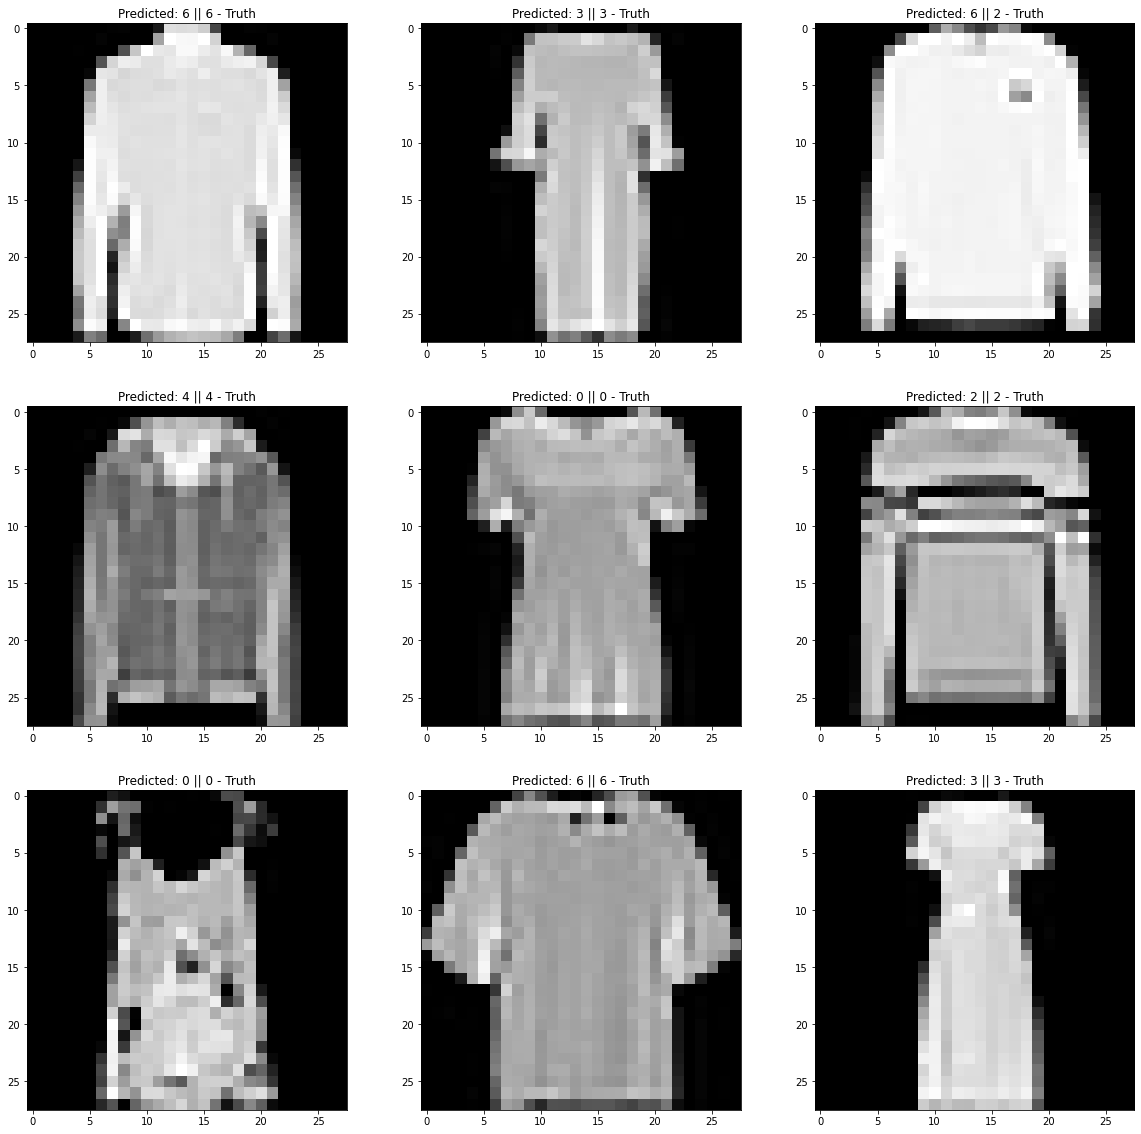

In [11]:
plt.figure(figsize=[20, 20])
for example in range(9):
    index = np.random.randint(100)
    output = network.forward(train_dataset[index][0])
    probabilities = np.exp(output) / np.exp(output).sum(axis=-1, keepdims=True)
    prediction = probabilities.argmax()
    plt.subplot(3, 3, example + 1)
    plt.title('Predicted: {} || {} - Truth'.format(prediction, train_dataset[index][1]))
    plt.imshow(train_dataset[index][0].reshape(28, 28),cmap='gray')